# Effect of ReLU Activation on Hypercube

Need intuition.

### Trying to understand $f$ at Gaussian init

Already simulated


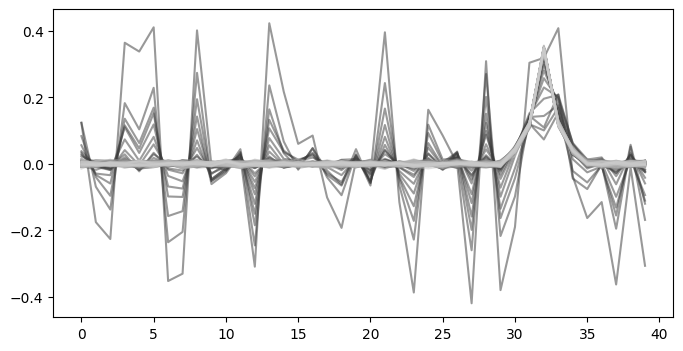

In [225]:
import numpy as np
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  dataset_cls=datasets.NonlinearGPDataset,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=100,
)

config = config_.copy()
config.update(dict(
    num_hiddens=1, learning_rate=0.1, num_epochs=1000, 
    # df=100000,
    gain=3, 
))

weights, metrics = simulate_or_load(**config)
_ = plot_rf_evolution(weights, figsize=(8, 4))

In [271]:
dataset_high = datasets.NonlinearGPDataset(key=jax.random.PRNGKey(0), num_dimensions=40, xi1=2, xi2=0.1, gain=100, num_exemplars=100000)
dataset_low = datasets.NLGPGaussianCloneDataset(key=jax.random.PRNGKey(0), num_dimensions=40, xi1=2, xi2=0.1, gain=100, num_exemplars=100000)
x, y = dataset_high[:100000]
x1h = x[y==1]
x0h = x[y==0]
x, y = dataset_low[:100000]
x1l = x[y==1]
x0l = x[y==0]

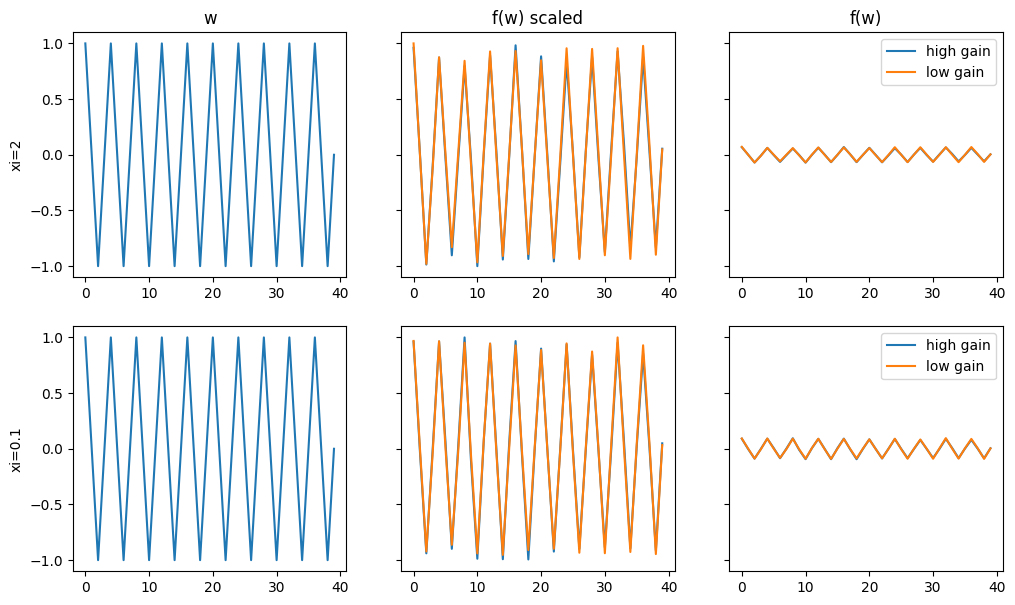

In [284]:
# w = jax.random.normal(key=jax.random.PRNGKey(0), shape=(40,1))
# w = jnp.cos(jnp.arange(40) * 2 * np.pi / 40).reshape(-1, 1)
# w = (-np.cos(np.arange(40)*10*np.pi/40) * np.exp(-(np.arange(40)-20)**2/3)).reshape(-1, 1)
# w = np.zeros((40,1)); w[15] = 2.1; w[16] = 1; w[17] = 1
# w = np.zeros((40,1)); w[15] = 2.1; w[25] = 1; w[35] = 1
# w = np.zeros((40,1)); w[15] = 2; w[25] = 1; w[35] = 1
# w = np.zeros((40,1)); w[15] = 1.5; w[25] = 1; w[35] = 1
# w = weights[0].T
w = np.zeros((40,1)); w[::4] = 1; w[2::4] = -1
fw1h = (x1h * ((x1h @ w) >= 0)).mean(axis=0)
fw0h = (x0h * ((x0h @ w) >= 0)).mean(axis=0)
fw1l = (x1l * ((x1l @ w) >= 0)).mean(axis=0)
fw0l = (x0l * ((x0l @ w) >= 0)).mean(axis=0)
fig, axs = plt.subplots(2, 3, figsize=(12, 7), sharey=True)
_ = axs[0,0].plot(w)
_ = axs[0,1].plot(fw1h * np.abs(w).max() / np.abs(fw1h).max(), label='high gain')
_ = axs[0,2].plot(fw1h, label='high gain')
_ = axs[0,1].plot(fw1l * np.abs(w).max() / np.abs(fw1l).max(), label='low gain')
_ = axs[0,2].plot(fw1l, label='low gain')
_ = axs[0,2].legend()
_ = axs[1,0].plot(w)
_ = axs[1,1].plot(fw0h * np.abs(w).max() / np.abs(fw0h).max(), label='high gain')
_ = axs[1,2].plot(fw0h, label='high gain')
_ = axs[1,1].plot(fw0l * np.abs(w).max() / np.abs(fw0l).max(), label='low gain')
_ = axs[1,2].plot(fw0l, label='low gain')
_ = axs[1,2].legend()
_ = axs[0,0].set_title('w')
_ = axs[0,1].set_title('f(w) scaled')
_ = axs[0,2].set_title('f(w)')
_ = axs[0,0].set_ylabel('xi=2')
_ = axs[1,0].set_ylabel('xi=0.1')

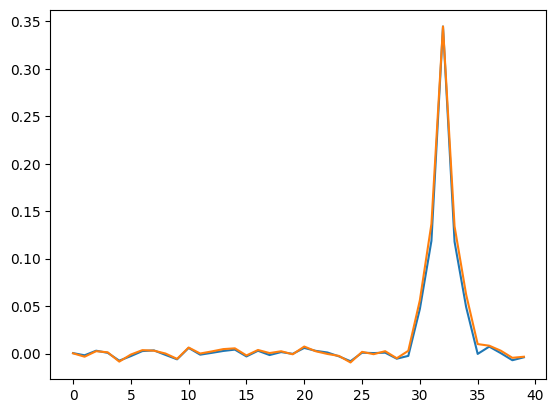

In [269]:
# xx1h = (x1h.T @ x1h) / len(x1h)
# xx0h = (x0h.T @ x0h) / len(x0h)
# plt.plot(w)
# fw = (0.1 * xx1h + xx0h) @ w
# plt.plot(fw * np.abs(w).max() / np.abs(fw).max())

### Trying to understand $k$ at Gaussian init

The condition I came up with seems way too strict.
I will have to relax this somehow to explain push towards localization early on.
Trying to understand what $f$ looks like early in training next.

November 24

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [19]:
n = 40
# x = np.array(list(product([-1,1], repeat=n)))

In [46]:
def f_k(w, max=12):
    w = -np.sort(-w)
    # assume w is sorted
    w_abs = np.abs(w)
    for k in range(1,len(w)+1):
        x = np.array(list(product([-1,1], repeat=k)))
        m = np.abs(x @ w[:k]).min()
        print(m, w_abs[k:].sum())
        if m > w_abs[k:].sum():
            return k
        if k > max:
            return -1
    return len(w)

2.3366680757215987 31.278700606967686
0.28724455869847043 29.22927708994456
1.4978846188944264 27.44414791235166
0.1496016521160255 26.095864945573258
0.07780601564658673 24.76537948155324
0.14888971688670782 23.435605952762543
0.07358143614021206 22.257219875758643
0.023000216056499934 21.204723299584955
0.002983805514786275 20.315452282980907
0.021947514516337918 19.54461502609474
0.00045366639684907284 18.820409126117323
0.0025810596628108584 18.176640122821556
0.0002128059000181537 17.5372001170291


-1

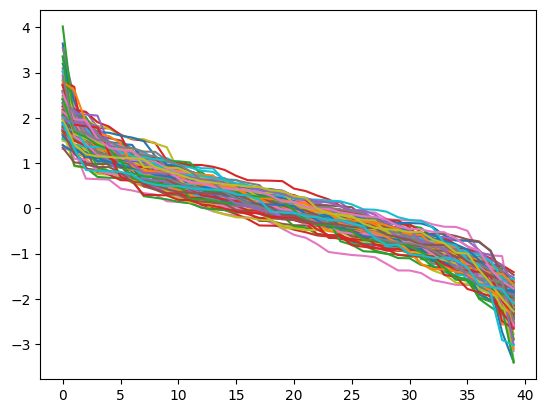

In [47]:
num_samples = 100
w = -np.sort(-np.random.normal(size=(num_samples,n)), axis=1)
_ = plt.plot(w.T)
f_k(w[0])

1.0 1.0937337934806106
0.4933358513607894 0.5870696448413998
0.013328297278420997 0.08040549620218951
0.013328240260882529 0.08040543918465101
0.013328183243344038 0.08040538216711252
0.013328182700029842 0.08040538162379832
0.013328182156715645 0.08040538108048412
0.01332818215538667 0.0804053810791551
0.013328182154057643 0.08040538107782608
0.013328182154057643 0.08040538107782608
0.013328182154057643 0.08040538107782608
0.013328182154057733 0.08040538107782608
0.013328182154057733 0.08040538107782608


-1

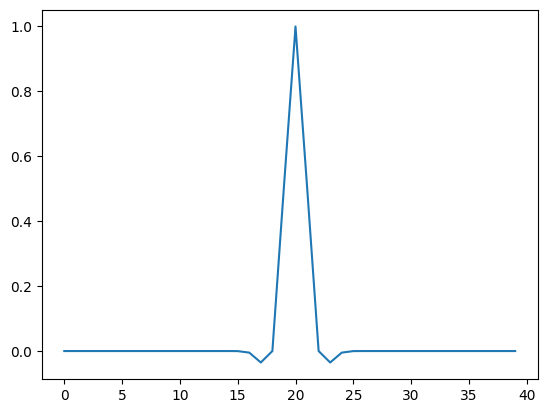

In [50]:
w = -np.cos(np.arange(n)*10*np.pi/n) * np.exp(-(np.arange(n)-20)**2/3)
_ = plt.plot(w)
f_k(w)

In [45]:
w[np.abs(w) > 0.05]

array([-0.07452851,  0.55069531,  1.        ,  0.55069531, -0.07452851])

### November 22-23

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
n = 20
x = np.array(list(product([-1,1], repeat=n)))

In [3]:
import optax
import matplotlib.pyplot as plt
from localization import datasets
from localization import models
from localization import samplers
from localization.experiments import simulate, simulate_or_load, make_key
from localization.utils import plot_receptive_fields, plot_rf_evolution, build_gaussian_covariance, build_non_gaussian_covariance, entropy_sort

config_ = dict(
  # data config
  num_dimensions=40,
  xi1=2,
  xi2=1,
  dataset_cls=datasets.NonlinearGPDataset,
  batch_size=1000,
  support=(-1, 1),
  class_proportion=0.5,
  # model config
  model_cls=models.SimpleNet,
  activation='relu',
  use_bias=False,
  sampler_cls=samplers.EpochSampler,
  init_fn=models.xavier_normal_init,
  init_scale=1.,
  optimizer_fn=optax.sgd,
  # experiment config
  seed=0,
  save_=True,
  evaluation_interval=100,
)

config = config_.copy()
config.update(dict(
    num_hiddens=1, learning_rate=0.1, num_epochs=1000, 
    # df=100000,
    gain=3, 
))

weights, metrics = simulate_or_load(**config)
w = weights[:,0,::2]

Already simulated


In [16]:
# single w
w = np.abs(w)
w = w[np.argsort(w)[::-1]]
p = np.mean(x[x @ w >= 0], axis=0)
p

array([0.66169739, 0.25057983, 0.23191071, 0.17990875, 0.15484619,
       0.12498474, 0.09945679, 0.09629822, 0.09148407, 0.0851593 ,
       0.08209229, 0.08104706, 0.07471466, 0.05706024, 0.05375671,
       0.04060364, 0.03862   , 0.03842926, 0.03588867, 0.02357483])

In [18]:
# multiple samples of w
# s = 1000
# w = np.random.normal(size=(s,n))
# w = np.random.rand(s,n)
# w[:,0] *= 2
# w = np.cos(2*np.pi*np.arange(n)/n)
w = np.abs(w)
w = np.apply_along_axis(lambda w_: w_[np.argsort(w_)[::-1]], 1, w)
p = np.apply_along_axis(lambda w_: np.mean(x[x @ w_ >= 0], axis=0), 1, w)

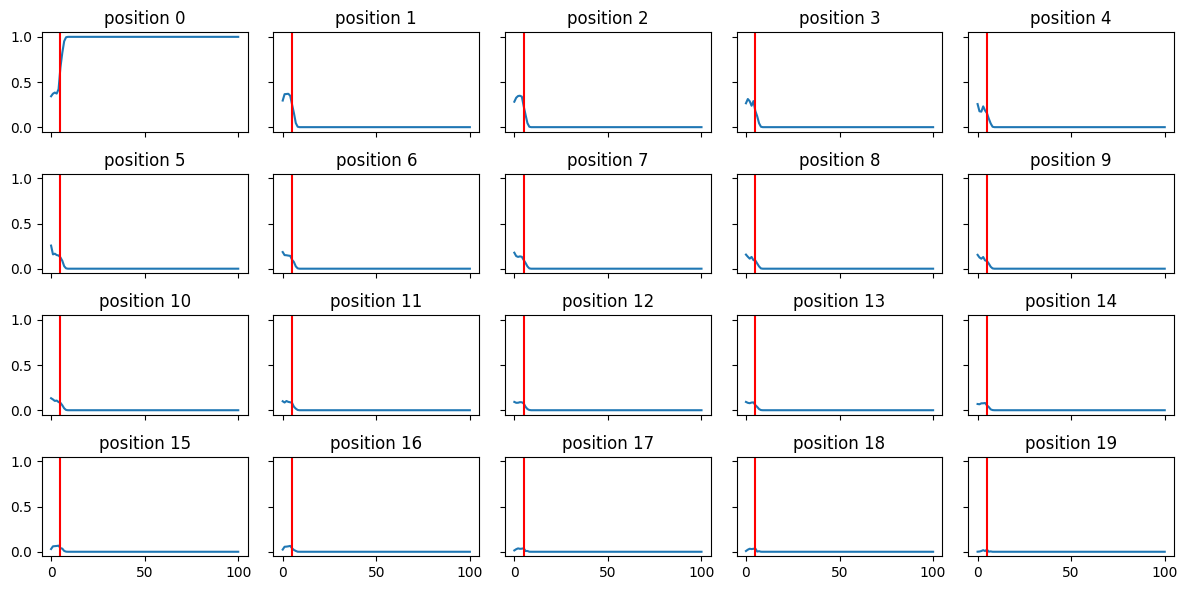

In [27]:
fig, axs = plt.subplots(4, 5, figsize=(12, 6), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.plot(p[:,i])
    ax.set_title(f'position {i}')
    ax.axvline(5, color='r')
fig.tight_layout()

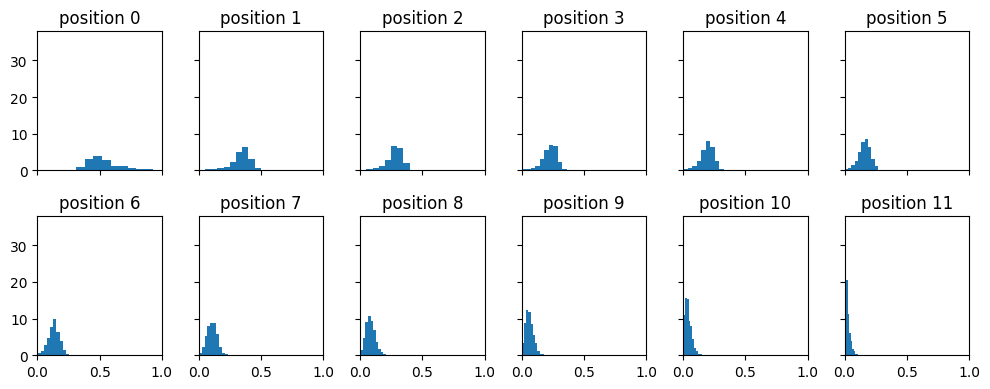

In [93]:
fig, axs = plt.subplots(2, 6, figsize=(10, 4), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.hist(p[:,i], density=True)
    ax.set_title(f'position {i}')
    ax.set_xlim(0,1)
fig.tight_layout()